In [25]:
'''This script examines several methods to for aspect modelling.
The models are then saved for predicting aspects for a new, unseen review.'''

'This script examines several methods to for aspect modelling.\nThe models are then saved for predicting aspects for a new, unseen review.'

# Import libraries

In [26]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


import pandas as pd
import numpy as np
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             hamming_loss, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from skmultilearn.model_selection import IterativeStratification

from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3)

import pyLDAvis
from pyLDAvis import gensim_models

pyLDAvis.enable_notebook()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gawai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Define Functions

In [27]:
def stratified_split (X, Y, test_size):
    '''Stratified train-test split given specified test_size'''
    stratifier = IterativeStratification(n_splits=2, order=2,
                                         sample_distribution_per_fold=[test_size, 
                                                                       1-test_size])
    train_indexes, test_indexes = next(stratifier.split(X, Y))
    X_train, Y_train = X[train_indexes], Y.iloc[train_indexes, :]
    X_test, Y_test = X[test_indexes], Y.iloc[test_indexes, :]
    return X_train, X_test, Y_train, Y_test


def evaluate_model(model, X_train, Y_train, n_folds=3):
    '''Evaluate a model using stratified k-fold cross-validation.
    prints out mean accuracy, mean hamming loss, and mean f1-score across folds'''
    acc_train = []
    acc_test = []
    loss_train = []
    loss_test = []
    f1_train = []
    f1_test =[]

    k_fold = IterativeStratification(n_splits=n_folds, order=2)

    for tr_index, ts_index in k_fold.split(X_train, Y_train):
        model.fit(X_train[tr_index], Y_train.iloc[tr_index])
        pred_train = model.predict(X_train[tr_index])
        pred_test = model.predict(X_train[ts_index])
        acc_train.append(accuracy_score(Y_train.iloc[tr_index], pred_train))
        acc_test.append(accuracy_score(Y_train.iloc[ts_index], pred_test))
        loss_train.append(hamming_loss(Y_train.iloc[tr_index], pred_train))
        loss_test.append(hamming_loss(Y_train.iloc[ts_index], pred_test))
        f1_train.append(f1_score(Y_train.iloc[tr_index], pred_train, average='micro'))
        f1_test.append(f1_score(Y_train.iloc[ts_index], pred_test, average='micro'))

    print('Train set:\n')
    print(f'Mean accuracy score: {np.mean(acc_train)}, \n'
          f'Mean loss: {np.mean(loss_train)}, \n'
          f'Mean F1-score:{np.mean(f1_train)}')
    print('\nTest set:\n')
    print(f'Mean accuracy score: {np.mean(acc_test)}, \n'
          f'Mean loss: {np.mean(loss_test)}, \n'
          f'Mean F1-score:{np.mean(f1_test)}')


def preprocess_text(text):
    '''Preprocess and convert a text into tokens for topic modeling'''
    text = remove_stopwords(text)
    tokens = simple_preprocess(text)
    tokens_lem = [WordNetLemmatizer().lemmatize(token, pos='v') for token in tokens]
    processed = [token for token in tokens_lem if len(token) > 3]
    return processed


def topic_aspect_corplot(topics_aspects):
    '''plots correlation between labelled aspects and extracted topics.'''
    labels = topics_aspects.columns
    mask = np.zeros_like(topics_aspects.corr())
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(22, 22))
    sns.heatmap(topics_aspects.corr(), 
                xticklabels=labels, 
                yticklabels=labels, 
                cmap="RdBu_r", 
                mask=mask,
                annot=True)
    plt.title('Correlation between aspects and topics', fontsize=30)
    plt.show()

# Load Data

In [29]:
pwd_text_df = pd.read_csv('../data/pwd_text.csv')
pwd_text_df

,pwd,headline,text
0,CKL,my_preferred_environment_physical_physical,i prefer quiet environment.
1,CKL,my_preferred_environment_social_social,i can still respond to my name through eye con...
2,CKL,my_preferred_environment_social_social,"by calling my name during care interventions, ..."
3,CKL,my_preferred_environment_social_social,i can maintain good eye contact with staff.
4,CKL,diagnosis_code,irms secondary diagnosis: 1. dm\r\nhtn\r\nrt a...
...,...,...,...
1370,PSP,general_general_observation,nil other complaints precaution: fall (require...
1371,PSP,mobility_status_gait_analysis,able to ambulate about 40m in home level under...
1372,PSP,mobility_status_gait_analysis,require rest after ~40m due to dyspnoea.
1373,PSP,mobility_status_problem_list,morning group exercise ios 2. assisted ambulat...


# Topic Modeling
Unsupevised topic extraction is performed using 3 topic modeling methods:
1. Latent Dirichlet Allocation (LDA)
2. Non-negative Matrix Factorization (NMF) using Frobenius norm
3. NMF using generalized Kullback-Leibler divergence  

## 1. LDA

In [30]:
# Preprocess the text collected relating to the PWD's status for LDA
text_collection = [preprocess_text(text) for text in pwd_text_df['text']]

# Create dictionary and corpus
dictionary = corpora.Dictionary(text_collection)

# convert tokenized documents into a bag of words corpus
corpus_bow = [dictionary.doc2bow(text) for text in text_collection]

# Using TF-IDF instead of bag-of-words
# an improvement may be to use dense sentence embeddings instead of tf-idf

tfidf = models.TfidfModel(corpus_bow) 
corpus_tfidf = tfidf[corpus_bow]

# num_topics refers to the number of topics to be identified
num_topics = 8
ldamodel = models.ldamodel.LdaModel(corpus_bow, num_topics=num_topics,
                                    id2word=dictionary, passes=25,
                                    random_state=42)
pprint(ldamodel.print_topics())

[(0,
  '0.052*"able" + 0.044*"follow" + 0.036*"instructions" + 0.030*"step" + '
  '0.027*"cognition" + 0.021*"remark" + 0.018*"consistently" + 0.014*"good" + '
  '0.012*"attention" + 0.012*"conversation"'),
 (1,
  '0.039*"diagnosis" + 0.038*"dementia" + 0.029*"irms" + 0.028*"secondary" + '
  '0.020*"vascular" + 0.018*"right" + 0.017*"leave" + 0.015*"fracture" + '
  '0.014*"primary" + 0.011*"pain"'),
 (2,
  '0.027*"pain" + 0.020*"activity" + 0.019*"resident" + 0.017*"unable" + '
  '0.016*"complaints" + 0.016*"engagement" + 0.015*"discomfort" + '
  '0.014*"evaluation" + 0.014*"session" + 0.014*"activities"'),
 (3,
  '0.030*"mobility" + 0.027*"supervision" + 0.024*"adls" + 0.021*"behaviour" + '
  '0.018*"independent" + 0.018*"generally" + 0.016*"physical" + 0.015*"feed" + '
  '0.015*"assist" + 0.015*"dress"'),
 (4,
  '0.024*"live" + 0.023*"room" + 0.017*"change" + 0.016*"area" + '
  '0.013*"significant" + 0.012*"respond" + 0.011*"like" + 0.011*"watch" + '
  '0.011*"calm" + 0.011*"staff"')

In [31]:
# visualization
gensim_models.prepare(ldamodel, corpus_bow, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.160232  0.128341       1        1  20.474142
1      0.193714  0.028993       2        1  12.713203
0     -0.072187 -0.228061       3        1  12.630034
3     -0.145809  0.076793       4        1  12.461829
6      0.143758  0.126865       5        1  11.218019
7      0.073105 -0.119326       6        1  11.190832
2     -0.078067 -0.006377       7        1  10.188454
4      0.045717 -0.007228       8        1   9.123487, topic_info=             Term        Freq       Total Category  logprob  loglift
126        follow   68.000000   68.000000  Default  30.0000  30.0000
134          able  139.000000  139.000000  Default  29.0000  29.0000
105      exercise  110.000000  110.000000  Default  28.0000  28.0000
203  instructions   55.000000   55.000000  Default  27.0000  27.0000
26      diagnosis   75.000000   75.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
118          note    6.402240   43.375444   Topic8  -5.1390   0.4811
3         contact    5.937697   32.819987   Topic8  -5.2144   0.6846
44          leave    6.268130   77.208796   Topic8  -5.1602  -0.1167
23       dementia    5.845331   79.310486   Topic8  -5.2300  -0.2134
417         lower    5.339719   24.768346   Topic8  -5.3205   0.8599

[453 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
134       1  0.250572     able
134       3  0.565576     able
134       4  0.042955     able
134       6  0.093069     able
134       7  0.042955     able
...     ...       ...      ...
163       8  0.472433    watch
104       5  0.970804     week
471       8  0.811136  workers
94        6  0.838770   xavier
94        7  0.114378   xavier

[832 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 1, 4, 7, 8, 3, 5])

In [33]:
# Save the lda model
ldamodel.save('lda.model')

### Develop LDA Model Object for easier comparison

In [34]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


import pandas as pd
import numpy as np
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             hamming_loss, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from skmultilearn.model_selection import IterativeStratification

from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from yake import KeywordExtractor

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

sns.set(font_scale=1.3)

import pyLDAvis
from pyLDAvis import gensim_models

pyLDAvis.enable_notebook()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gawai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [103]:
class modelLDA:
    def __init__(self, df, num_topics, passes=25, random_state=42):
        self.df = df.copy()
        # process the text again for the LDA model's use 
        self.text_collection = [self.preprocess_text(text) for text in self.df['text']]

        # Create dictionary and corpus
        self.dictionary = corpora.Dictionary(self.text_collection)

        # convert tokenized documents into a bag of words corpus
        self.corpus_bow = [self.dictionary.doc2bow(text) for text in self.text_collection]

        # Using TF-IDF instead of bag-of-words

        self.tfidf = models.TfidfModel(self.corpus_bow) 
        self.corpus_tfidf = self.tfidf[self.corpus_bow]

        # num_topics refers to the number of topics to be identified
        self.num_topics = num_topics
        self.passes = passes
        self.random_state = random_state
        self.ldamodel = models.ldamodel.LdaModel(self.corpus_bow, 
                                                 num_topics=self.num_topics,
                                                 id2word=self.dictionary, 
                                                 passes=self.passes,
                                                 random_state=self.random_state)
        self.topic_probabilities = self.get_topic_probabilities()

    def preprocess_text(self, text):
        '''Preprocess and convert a text into tokens for topic modeling'''
        # initialise YAKE keyword extractor
        kw_extractor = KeywordExtractor()

        text = remove_stopwords(text)
        keywords = [keyword for keyword, score in kw_extractor.extract_keywords(text)]
        # tokens = simple_preprocess(text)
        tokens_lem = [WordNetLemmatizer().lemmatize(keyword, pos='v') for keyword in keywords]
        processed = [token for token in tokens_lem if len(token) > 3]
        return processed

    def get_visualisation(self):
        # visualise the results of the LDA model
        lda_visualisation = gensim_models.prepare(self.ldamodel, self.corpus_bow, self.dictionary, sort_topics=False)

        # note that the output visualisation has the topic indexes starting from 1 instead of 0
        return lda_visualisation

    def get_topics_scores(self, corpus, ldamodel):
        '''get the scores associated with all topics for a single review'''
        scores = [[score for _, score in ldamodel.get_document_topics(sentence_bow, minimum_probability=0)] for sentence_bow in corpus]
        return list(scores)

    def get_topic_probabilities(self):
        # organize the results (topics probabilities) for all reviews in a data frame
        topics_probabilities = self.get_topics_scores(self.corpus_bow, self.ldamodel)
        
        topics_probabilities = pd.DataFrame(topics_probabilities)

        topics_probabilities.columns = ['lda_topic_index_' + str(col+1) 
                                for col in topics_probabilities.columns]
        
        return topics_probabilities
    
    def get_topics(self):
        '''
            Get the topics and add it to the dataframe inserted from the initialisation function
        '''
        probs_df = self.topic_probabilities
        predictions_df = self.df.copy()
        predictions_df['predicted_topic'] = probs_df.idxmax(axis=1)
        return predictions_df
    
    def get_topic_distribution(self, predicted_topics):
        '''
            Get the distributions of the topics in the 'predicted_topic' columns
        '''
        # Plotting the bar graph
        plt.figure(figsize=(10, 6))
        predicted_topics.value_counts().plot(kind='bar')
        plt.xlabel('Topic')
        plt.ylabel('Frequency')
        plt.title('Frequency of topics')
        plt.show()

    def get_topic_wordcloud(self, predictions_df):
        '''
            Get the word cloud of the words that exist for each topic.
        '''
        # WordCloud Visualization
        fig = plt.figure(figsize=(20, 8))
        topics = list(self.topic_probabilities.columns)
        for i, topic in enumerate(topics):
            subset = predictions_df[predictions_df['predicted_topic'] == topic]

            # preprocess the subset text
            subset['text'] = subset['text'].apply(lambda x: ' '.join(self.preprocess_text(x)))
            
            cld = WordCloud(stopwords=STOPWORDS, background_color='black',
                            collocations=False, width=2500,
                            height=1800).generate(" ".join(subset['text']))
            ax = fig.add_subplot(3, 4, i+1)
            ax.set_title(topic, fontsize=18)
            ax.axis('off')
            ax.imshow(cld)

    def get_tfidf_for_topics(self):
        '''
            Get the TF-IDF scores for different topics identified by the LDA model.
        '''
        # initialise a TfidfVectorizer object
        tfidf_vectorizer = TfidfVectorizer()
        
        # fit and transform the text data to TF-IDF
        flattened_documents = [' '.join(text) for text in self.text_collection]
        tfidf_matrix = tfidf_vectorizer.fit_transform(flattened_documents)
        tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()


        # Initialize an empty DataFrame to store TF-IDF scores for each topic
        tfidf_df = pd.DataFrame(index=range(self.num_topics), columns=tfidf_feature_names)

        # Calculate TF-IDF scores for each topic
        for topic_id in range(self.num_topics):
            doc_indices = self.topic_probabilities[self.topic_probabilities.idxmax(axis=1) == f'lda_topic_index_{topic_id+1}'].index
            if not len(doc_indices):
                continue
            
            # Extract the submatrix for the documents in this topic
            submatrix = tfidf_matrix[doc_indices, :]
            mean_tfidf = np.mean(submatrix, axis=0).A1  # Convert to a 1D array
            
            # Assign the mean TF-IDF scores to the DataFrame
            tfidf_df.loc[topic_id] = mean_tfidf
        
        # change the index to start from 1, following the pyLDAvis standard
        tfidf_df.index = list(range(1, self.num_topics+1))
        
        # Set the index name to 'topic_index'
        tfidf_df.index.name = 'topic_index'


        return tfidf_df
    
    def get_top_n_words(self, num_top_words):
        # Get the top n words for each topic

        for topic_idx, topic in self.ldamodel.show_topics(num_topics=num_topics, num_words=num_top_words, formatted=False):
            top_words = [word for word, _ in topic]
            print(f"Topic {topic_idx+1}:")
            print(', '.join(top_words))
            print('\n')
                


In [36]:
pwd_text_df = pd.read_csv('../data/pwd_text.csv')

### Identifying 9 Topics 

In [37]:
# train an LDA model to identify 9 separate topics
num_topics = 9
lda_model = modelLDA(pwd_text_df, num_topics=num_topics, passes=35, random_state=42)

In [38]:
lda_model_predictions_df = lda_model.get_topics()
lda_model_predictions_df

,pwd,headline,text,predicted_topic
0,CKL,my_preferred_environment_physical_physical,i prefer quiet environment.,lda_topic_index_5
1,CKL,my_preferred_environment_social_social,i can still respond to my name through eye con...,lda_topic_index_7
2,CKL,my_preferred_environment_social_social,"by calling my name during care interventions, ...",lda_topic_index_3
3,CKL,my_preferred_environment_social_social,i can maintain good eye contact with staff.,lda_topic_index_4
4,CKL,diagnosis_code,irms secondary diagnosis: 1. dm\r\nhtn\r\nrt a...,lda_topic_index_1
...,...,...,...,...
1370,PSP,general_general_observation,nil other complaints precaution: fall (require...,lda_topic_index_3
1371,PSP,mobility_status_gait_analysis,able to ambulate about 40m in home level under...,lda_topic_index_6
1372,PSP,mobility_status_gait_analysis,require rest after ~40m due to dyspnoea.,lda_topic_index_5
1373,PSP,mobility_status_problem_list,morning group exercise ios 2. assisted ambulat...,lda_topic_index_5


In [39]:
# setting relevance metric to 0 in order to observe the words with highest tf-idf score for the topic
lda_model.get_visualisation()

# adjust relevance metric to 1 to show the words which are most useful at differentiating the different text

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.044983  0.141020       1        1  13.314376
1      0.042912  0.029524       2        1   9.560788
2      0.076361 -0.120508       3        1  11.259687
3      0.051711 -0.049423       4        1  11.141264
4     -0.209312 -0.073219       5        1  17.494743
5      0.015792  0.054806       6        1  11.098491
6      0.015636 -0.024309       7        1   9.155311
7      0.044715  0.019216       8        1   7.971809
8      0.007167  0.022894       9        1   9.003531, topic_info=                                Term       Freq      Total Category  logprob  \
862                     instructions  32.000000  32.000000  Default  30.0000   
159  recommended maintenance therapy  25.000000  25.000000  Default  29.0000   
312                        cognition  28.000000  28.000000  Default  28.0000   
327                             step  31.000000  31.000000  Default  27.0000   
158          recommended maintenance  23.000000  23.000000  Default  26.0000   
..                               ...        ...        ...      ...      ...   
61                         therapist   1.875540   9.735512   Topic9  -6.6167   
143                         physical   1.875512  20.194749   Topic9  -6.6167   
806                            reply   1.875491   7.701066   Topic9  -6.6167   
761                             time   1.875440  31.538992   Topic9  -6.6168   
1                             prefer   1.875400  33.856194   Topic9  -6.6168   

     loglift  
862  30.0000  
159  29.0000  
312  28.0000  
327  27.0000  
158  26.0000  
..       ...  
61    0.7607  
143   0.0310  
806   0.9951  
761  -0.4148  
1    -0.4857  

[532 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
62        2  0.538387  aca mca infarcts
299       1  0.081844        activities
299       2  0.081844        activities
299       3  0.136406        activities
299       4  0.109125        activities
...     ...       ...               ...
161       1  0.040930              week
161       5  0.900450              week
138       2  0.720693            xavier
138       3  0.166314            xavier
138       5  0.055438            xavier

[1028 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9])

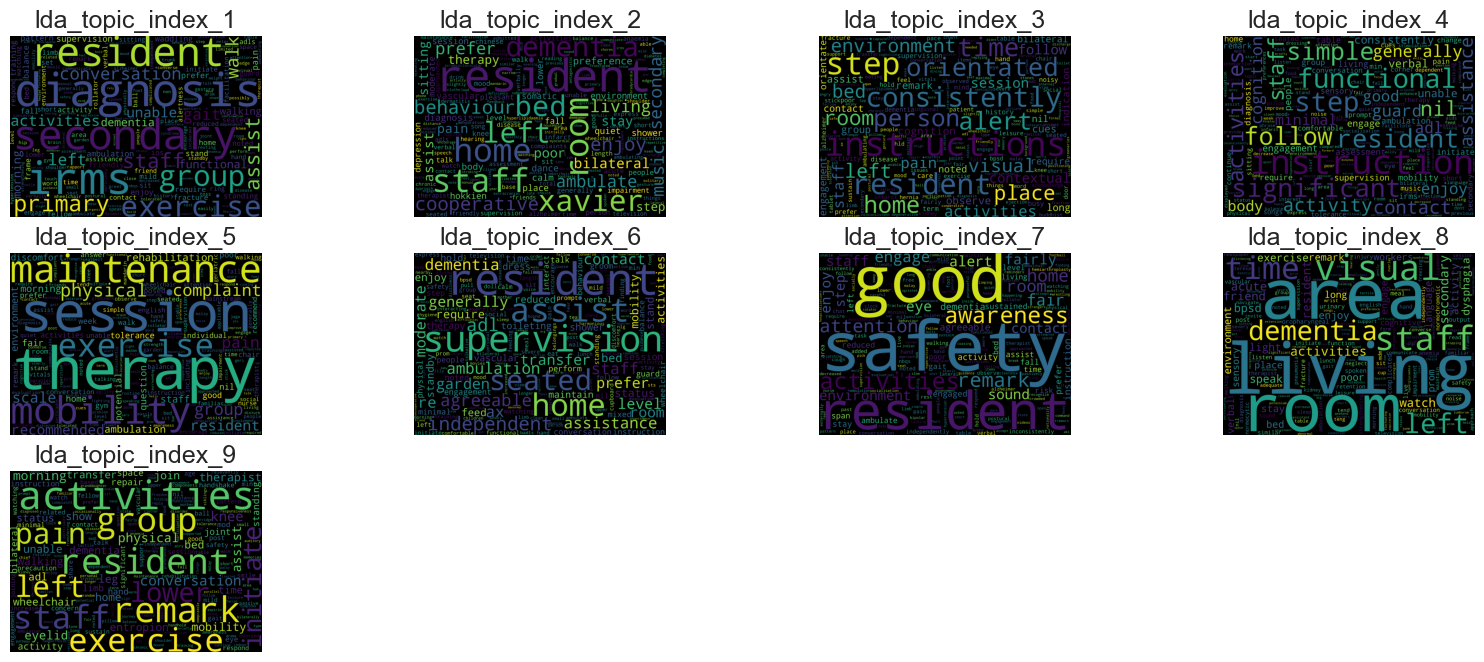

In [40]:
# identify the most frequent individual words in each topic and show it in a word cloud
lda_model.get_topic_wordcloud(lda_model_predictions_df)

In [41]:
# identify the most unique and differentiable words in each topic
lda_model.get_tfidf_for_topics()

,10,11,14,15,17,19,2014,23,24,25,...,wrist,write,xavier,year,years,yes,yeu,zhou,zosters,zumba
topic_index,,,,,,,,,,,,,,,,,,,,,
1,0.002215,0.0,0.0,0.001431,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.001151,0.000502,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.002387,0.002616,0.0,0.0,0.0,0.002476,0.0,...,0.004922,0.0,0.1213,0.004095,0.0,0.0,0.0,0.0,0.0,0.002338
3,0.0,0.000621,0.0,0.0,0.0,0.0,0.0,0.000621,0.0,0.0,...,0.0,0.0,0.008655,0.0,0.000578,0.00052,0.0,0.0,0.0,0.0
4,0.00126,0.0,0.0,0.001209,0.0,0.002479,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.00058,0.0,0.0,0.0,...,0.0,0.0,0.000429,0.0,0.00042,0.001434,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00258,0.0,0.0,0.0,0.004027,0.003207,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.002005,0.0,0.0,0.002005,0.002119,...,0.001072,0.0,0.0,0.006304,0.0,0.0,0.0,0.0,0.000819,0.0
8,0.0,0.0,0.001127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00568


In [42]:
# based on the above results identify keywords associated with the following 9 categories
ldaTopic_to_aspect = {
    'MY UNIQUE EXPERIENCES': [],
    'MY PREFERRED ENVIRONMENT - Physical': ['service'],
    'MY PREFERRED ENVIRONMENT - Social': ['staff'],
    'MY PHYSICAL STRENGTHS': [],
    'MY OCCUPATIONAL ABILITIES': ['service', 'ambience'],
    'MY PREFERRED ROUTINE': ['menu'],
    'MY HEALTH - Physical': ['price'],
    'MY HEALTH - Mental': [],
    'MY NEUROLOGICAL IMPAIRMENT': []
}

In [43]:
# the 9 topics identified from the living well plan
# topics = [
#     'MY UNIQUE EXPERIENCES',
#     'MY PREFERRED ENVIRONMENT - Physical',
#     'MY PREFERRED ENVIRONMENT - Social',
#     'MY PHYSICAL STRENGTHS',
#     'MY OCCUPATIONAL ABILITIES',
#     'MY PREFERRED ROUTINE',
#     'MY HEALTH - Physical',
#     'MY HEALTH - Mental',
#     'MY NEUROLOGICAL IMPAIRMENT'
# ]

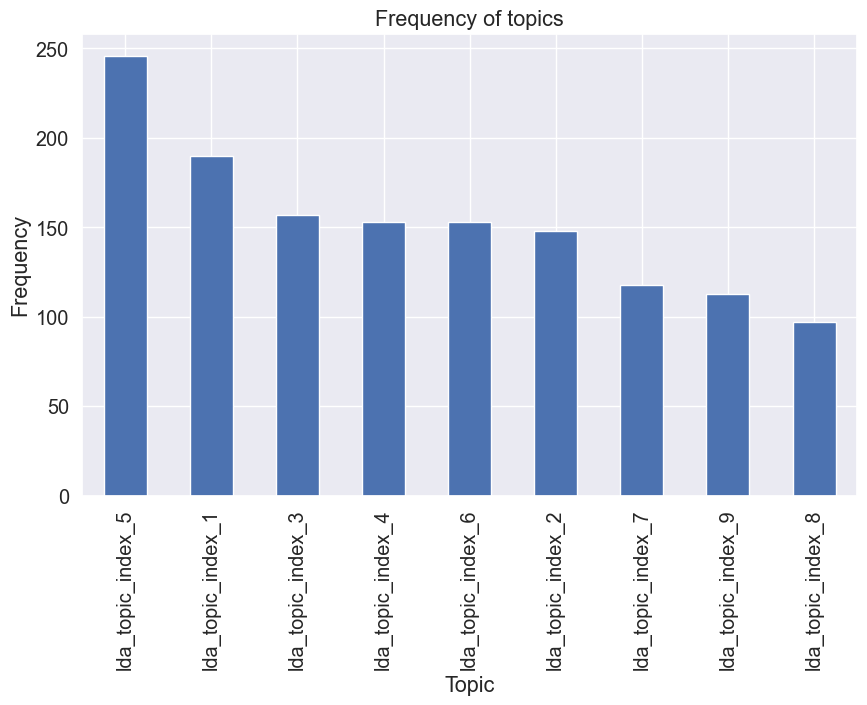

In [44]:
# identify the distribution of topics
lda_model.get_topic_distribution(lda_model_predictions_df['predicted_topic'])

## 2. NMF using Frobenius norm

In [48]:
# load the data
pwd_text_df = pd.read_csv('../data/pwd_text.csv')

In [70]:
# initialise keyword extractor
kw_extractor = KeywordExtractor()

In [71]:
# conduct preprocessing before putting it into the model
def preprocess_text(text):
    '''Preprocess and convert a text into tokens for topic modeling'''
    text = remove_stopwords(text)
    keywords = [keyword for keyword, score in kw_extractor.extract_keywords(text)]
    # tokens = simple_preprocess(text)
    tokens_lem = [WordNetLemmatizer().lemmatize(keyword, pos='v') for keyword in keywords]
    processed = [token for token in tokens_lem if len(token) > 3]
    return ' '.join(processed)

In [72]:
# TfidfVectorizer with max_features=200
tv = TfidfVectorizer(max_features=200, ngram_range=(1, 2), 
                     strip_accents='unicode', lowercase=True, 
                     stop_words='english') 

X = tv.fit_transform(pwd_text_df['text'].apply(preprocess_text))

In [73]:
# use vectorized reviews, X (using tf-idf)

# let n_components be 9 as there are 9 topics to categorise in the dataset
n_components = 9 
nmf_fn = NMF(n_components=n_components, random_state=42)
topics = nmf_fn.fit_transform(X)

# Convert to dataframe
topics = pd.DataFrame(topics)
topics.columns = ['nmf_fn_topic_index_' + str(col+1) for col in topics.columns]
print(topics.shape)
topics.head()

(1375, 9)


,nmf_fn_topic_index_1,nmf_fn_topic_index_2,nmf_fn_topic_index_3,nmf_fn_topic_index_4,nmf_fn_topic_index_5,nmf_fn_topic_index_6,nmf_fn_topic_index_7,nmf_fn_topic_index_8,nmf_fn_topic_index_9
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000015,0.000000,0.125009
1,0.002402,0.0,0.005077,0.010618,0.002471,0.0,0.005595,0.007087,0.006888
2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,0.000191,0.0,0.020435,0.108302,0.016994,0.0,0.003665,0.006924,0.002938
4,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.374466,0.000000,0.000000


In [74]:
# Get the feature names (words)
feature_names = tv.get_feature_names_out()

H = nmf_fn.components_
# Display the top words in each topic
num_top_words = 30
for topic_idx, topic in enumerate(H):
    print(f"Topic {topic_idx+1}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))



Topic 1:
resident, agreeable, noted, bed, remarks, assist, alert, ambulation, ambulate, bilateral, ax, conversation, xavier, mood, therapist, unable, remark, initiate, perform, safety, seated, stand, orientated, rollator, supervision, time, assessment, walking, communicate, left
Topic 2:
pain, complaints, nil, discomfort, session, nil complaints, significant, evaluation, unable, knee, noted, left, significant functional, functional, post, fracture, walking, agreeable, bilateral, remark, gait, assist, walk, verbal, ax, level, mild, therapist, scale, pattern
Topic 3:
therapy, group, exercise, maintenance, maintenance therapy, morning, group exercise, recommended, rehabilitation, recommended maintenance, morning group, sessions, potential, ambulation, session, fair, rehabilitation potential, tolerance, therapy sessions, individual, exercise tolerance, week, poor, recommend, good, balance, exercises, gym, training, garden
Topic 4:
staff, residents, conversation, initiate, remarks, talk, fe

## 3. NMF using generalized Kullback-Leibler divergence

In [77]:
nmf_kl = NMF(n_components=9, random_state=42, beta_loss="kullback-leibler",
             solver="mu", max_iter=1000)

topics = nmf_kl.fit_transform(X)
topics = pd.DataFrame(topics)
topics.columns = ['nmf_kl_topic_index_' + str(col+1) for col in topics.columns]
topics

,nmf_kl_topic_index_1,nmf_kl_topic_index_2,nmf_kl_topic_index_3,nmf_kl_topic_index_4,nmf_kl_topic_index_5,nmf_kl_topic_index_6,nmf_kl_topic_index_7,nmf_kl_topic_index_8,nmf_kl_topic_index_9
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.416915e-01
1,9.964330e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
3,9.994373e-02,0.000000e+00,2.121006e-72,2.071643e-02,4.134092e-02,0.000000,0.000000e+00,1.557838e-25,0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.389092e-01,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...
1370,8.057499e-02,2.830020e-02,1.010932e-02,4.576691e-02,9.309739e-288,0.020087,2.079179e-02,3.926250e-02,1.405506e-69
1371,8.506589e-150,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.029129,0.000000e+00,1.133007e-01,0.000000e+00
1372,7.068679e-02,0.000000e+00,0.000000e+00,0.000000e+00,6.590140e-221,0.000000,0.000000e+00,2.469242e-289,0.000000e+00
1373,0.000000e+00,4.340606e-54,1.629541e-01,7.846160e-85,0.000000e+00,0.025249,0.000000e+00,3.441944e-02,3.762193e-67


In [78]:
# Get the feature names (words)
feature_names = tv.get_feature_names_out()

H = nmf_kl.components_
# Display the top words in each topic
num_top_words = 30
for topic_idx, topic in enumerate(H):
    print(f"Topic {topic_idx+1}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))



Topic 1:
resident, remarks, xavier, conversation, contact, noted, agreeable, initiate, alert, require, therapist, ax, remark, questions, eye, hand, perform, chair, body, guard, mood, hold, answer, talking, converse, contact guard, short, seated, maintain, orientated
Topic 2:
functional, significant, safety, nil, walking, awareness, lower, session, post, fair, safety awareness, significant functional, limb, rollator, frame, assessment, poor, walk, ambulation, hold, evaluation, min, status, reduced, seat, short, gym, standing, follow, exercises
Topic 3:
group, exercise, therapy, ambulation, maintenance, morning, balance, maintenance therapy, group exercise, garden, recommended, exercises, tolerance, rehabilitation, morning group, stand, recommended maintenance, ball, encourage, training, friends, gym, sessions, potential, join, fair, week, rehabilitation potential, exercise tolerance, recommend
Topic 4:
staff, pain, residents, complaints, discomfort, express, friendly, nil, food, remark,

In [ ]:
# Save the  model
joblib.dump(nmf_fn, 'nmf_kl.pkl');

## 4. Identifying Keywords for Each Topic

In [105]:
# load data
pwd_text_df = pd.read_csv('../data/pwd_text.csv')

In [106]:
# identify the salient keywords identified from the LDA model
# train an LDA model to identify 9 separate topics
num_topics = 9
lda_model = modelLDA(pwd_text_df, num_topics=num_topics, passes=35, random_state=42)
lda_model_predictions_df = lda_model.get_topics()

In [102]:
# use pyLDAvis to observe the most salient words and the clusters formed that are far from each other
lda_model.get_visualisation()

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.047119  0.141499       1        1  13.298559
1      0.045111  0.027445       2        1   9.570347
2      0.076399 -0.121814       3        1  11.255357
3      0.048477 -0.048189       4        1  11.106764
4     -0.209321 -0.073948       5        1  17.501402
5      0.015900  0.054682       6        1  11.100844
6      0.016243 -0.022048       7        1   9.153923
7      0.047209  0.019466       8        1   7.990958
8      0.007101  0.022907       9        1   9.021846, topic_info=                                Term       Freq      Total Category  logprob  \
862                     instructions  32.000000  32.000000  Default  30.0000   
159  recommended maintenance therapy  25.000000  25.000000  Default  29.0000   
312                        cognition  28.000000  28.000000  Default  28.0000   
327                             step  31.000000  31.000000  Default  27.0000   
158          recommended maintenance  23.000000  23.000000  Default  26.0000   
..                               ...        ...        ...      ...      ...   
162                         exercise   2.227581  32.302081   Topic9  -6.4467   
61                         therapist   1.877764   9.738305   Topic9  -6.6176   
917                         decrease   1.877760   8.198828   Topic9  -6.6176   
143                         physical   1.877720  20.189261   Topic9  -6.6176   
806                            reply   1.877715   7.704017   Topic9  -6.6176   

     loglift  
862  30.0000  
159  29.0000  
312  28.0000  
327  27.0000  
158  26.0000  
..       ...  
162  -0.2687  
61    0.7595  
917   0.9316  
143   0.0304  
806   0.9938  

[528 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
62        2  0.538059  aca mca infarcts
299       1  0.081821        activities
299       2  0.081821        activities
299       3  0.136369        activities
299       4  0.109095        activities
...     ...       ...               ...
161       1  0.040943              week
161       5  0.900746              week
138       2  0.720012            xavier
138       3  0.221542            xavier
138       5  0.055386            xavier

[1017 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9])

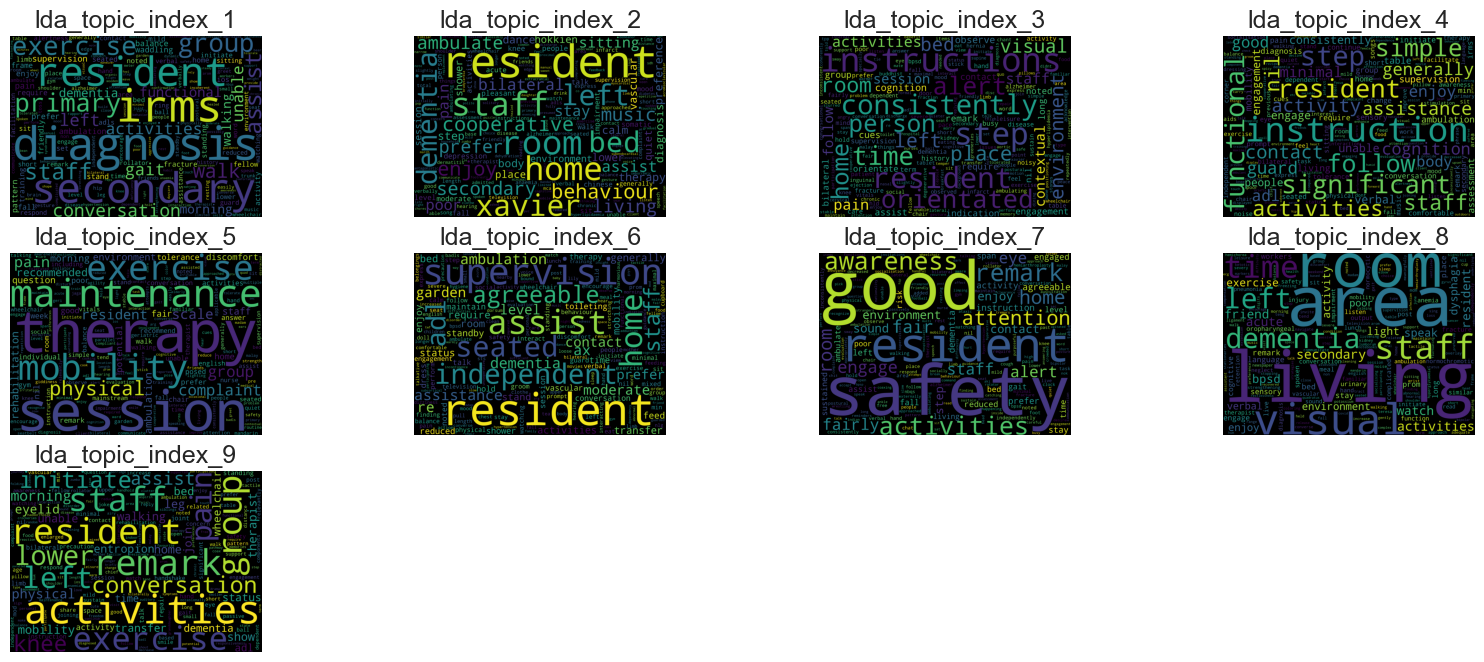

In [107]:
# observe the most common individual keywords i.e. 1-grams in each topic
lda_model.get_topic_wordcloud(lda_model_predictions_df)

In [108]:
lda_model.get_top_n_words(num_top_words=30)

Topic 1:
diagnosis, irms primary diagnosis, irms primary, primary diagnosis, irms, walk, irms secondary diagnosis, secondary diagnosis, irms secondary, primary, exercise, unable, assist, group, dementia, secondary, stand, staff, enjoy, morning group, morning, functional, pattern, prefer, gait pattern, conversation, initiate, friendly, unable walk, gait


Topic 2:
xavier, cooperative, behaviour, resident, calm, room, vascular dementia, prefer, ambulate, staff, shower, music, stay, activities, dementia, enjoy, generally, living room, pleasant, approach, admit, hokkien, home, note, live, lower, walk, chinese, people, feel


Topic 3:
instructions, cognition, step, alert, consistently, step instructions, instructions consistently, orientate, step instructions consistently, person, time, alert orientated, place, follow, follow 1-2 step, home, observe, pain, session, environment, orientated person, resident, activities, staff, alert orientated person, residents, remark, dependent, time place,

From observing the output words in each of the 9 topics that the LDA model categorised, I can observe that:
1) Topic 1 is likely a cluster of words and n-grams that are mostly associated with the topic of "MY HEALTH". 
- This can be observed as the most frequent keywords are diagnosis and irms, and the most salient terms are n-grams consisting of irms and diagnosis. 

- The contents of these sentences are likely the diagnosed conditions of the patient. 

- These conditions include both Physical and Mental. The keywords "walk", "exercise", "stand", "gait" and their corresponding n-grams suggest that these sentences are referencing the PWD's physical health. The keyword "dementia" suggests that the topic may also be referring to the mental health.

2) Topic 2 is likely a cluster of words and n-grams that are associated with the topic of "MY PREFERRED ENVIRONMENT". The keywords in particular are "cooperative", "behavior", "calm", and "pleasant". Some common noteworthy words however are 'home', 'room', 'bed' and 'music'. 

3) Topic 3 is strongly associated with "MY OCCUPATIONAL ABILITIES" which is further reinforced as from the pyLDAvis visualisation, we can observe that the cluster is further away from the other clusters (2, 4, 6, 7, 8, 9).
- The salient and frequent keywords consist of 'instructions', 'cognition', 'step', 'orientate', 'alert'

4) Topic 4 is also associated with "MY OCCUPATIONAL ABILITIES". 
- The salient and frequent keywords consist of 'instructions', 'step', 'follow instructions', 'follow steps'

5) Topic 5 is strongly associated with ""

In [ ]:
# based on the above results identify keywords associated with the following 9 categories
first_iteration_aspect_keywords = {
    'MY UNIQUE EXPERIENCES': [],
    'MY PREFERRED ENVIRONMENT - Physical': ['cooperative', 'behavior', 'calm', 'pleasant', 'home', 'room', 'bed'],
    'MY PREFERRED ENVIRONMENT - Social': ['cooperative', 'behavior', 'calm', 'pleasant', 'music'],
    'MY PHYSICAL STRENGTHS': [],
    'MY OCCUPATIONAL ABILITIES': ['instructions', 'cognition', 'step', 'orientate', 'alert', 'follow instructions', 'follow steps'],
    'MY PREFERRED ROUTINE': [],
    'MY HEALTH - Physical': ['irms', 'diagnosis', 'walk', 'exercise', 'stand', 'gait'],
    'MY HEALTH - Mental': ['irms', 'diagnosis', 'dementia'],
    'MY NEUROLOGICAL IMPAIRMENT': []
}